In [1]:
import cv2
import os
import numpy as np
from random import shuffle

In [2]:
TRAIN_DIR = '/Users/mackenzieboudreau/Downloads/train'
TEST_DIR = '/Users/mackenzieboudreau/Downloads/test'
IMG_SIZE = 50
LR = 1e-3 

MODEL_NAME = 'dogsvscat:{}:{}.model'.format(LR, '6conv-improv')


In [3]:
def labelImg(img):
    word_label = img.split('.')[-3]
    if (word_label == 'cat'): return [1,0]
    elif (word_label == 'dog'): return [0, 1]
    
def create_train_data():
    train_data = []
    i = 0
    j = 10
    for img in os.listdir(TRAIN_DIR):
        i += 1
        if (i % 2500 == 0):
            print(str(j) + "% DONE")
            j += 10
        label = labelImg(img)
        path = os.path.join(TRAIN_DIR, img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        train_data.append([np.array(img), np.array(label)])
    shuffle(train_data)
    np.save('train_data.npy', train_data)
    return train_data

In [4]:
def process_test_data():
    testing_data = []
    for img in os.listdir(TEST_DIR):
        path = os.path.join(TEST_DIR, img)
        img_num = img.split('.')[0]
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        testing_data.append([np.array(img), np.array(img_num)])
    np.save('test_comp.npy', testing_data)
    return testing_data

In [5]:
train_data = np.load('train_data.npy')

In [6]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

import tensorflow as tf

tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')


hdf5 is not supported on this machine (please install/reinstall h5py for optimal experience)


In [7]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

In [8]:
train = train_data[:-500]
test = train_data[-500:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

In [9]:
model.fit({'input': X}, {'targets': Y}, n_epoch=10, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 3829  | total loss: 0.36474 | time: 116.692s
| Adam | epoch: 010 | loss: 0.36474 - acc: 0.8287 -- iter: 24448/24500
Training Step: 3830  | total loss: 0.37610 | time: 119.013s
| Adam | epoch: 010 | loss: 0.37610 - acc: 0.8255 | val_loss: 0.46150 - val_acc: 0.7980 -- iter: 24500/24500
--


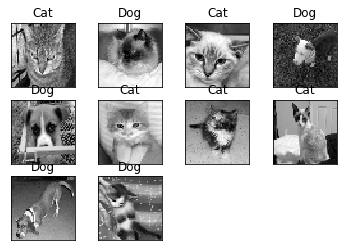

In [19]:
import matplotlib.pyplot as plt

# if you don't have this file yet
test_data = np.load('test_comp.npy')

fig = plt.figure()

for num, data in enumerate(test_data[12:22]):
    # cat = [1, 0]
    # dog = [0, 1]
    img_num = data[1]
    img_data = data[0]
    
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    model_out = model.predict([data])[0]
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig, cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()
    
    
    
    